In [2]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, BSpline
import numpy as np
from scipy import stats
import random
import math
from footprint_filter import filter_by_footprint
from voidiness import voidy_analysis
import pickle
import matplotlib.patches as mpatches
from custom_functions import z_mask, get_sim_idx

In [3]:
sdss_dr16 = pd.read_excel('exported_dataFrames/sdss_dr16_w_voidiness.xlsx')
four_lac = pd.read_excel('exported_dataFrames/4lac_w_voidiness.xlsx')
# hard_xrays = pd.read_excel('exported_dataFrames/SBAT104_w_voidiness.xlsx')
# soft_xrays = pd.read_excel('exported_dataFrames/ROMABZCAT_w_voidiness.xlsx')


In [44]:

sdss_dr16 = sdss_dr16.drop_duplicates(subset=['RAdeg', 'DEdeg'], keep='first')

In [161]:
is_qsr = sdss_dr16.AUTOCLASS_PQN == "QSO"
qsrs = sdss_dr16[is_qsr].copy()

# DROP ALL GALAXIES WITH z < 0.1
qsrs = qsrs[qsrs.z >= 0.1].copy()
four_lac = four_lac[four_lac.z > 0.1].copy()


In [162]:
len(qsrs)

19751

In [163]:
# # The mirror


# idx_buckets = [ [] for _ in range(6)]
# NFs = plt.hist([qsrs.z, four_lac.z]
#          ,histtype="step"
#          ,density=True
#          ,bins=binning)[0]
# tol = 0.1
# curve_unequal = [(NFs[0][i]  - NFs[1][i]) > tol for i in range(6)]
# while any(curve_unequal):
#     for i in range(6):
#         if curve_unequal[i]: # Too many galaxies in this bin!
#             # matplotlib's convention on bins: [left, right)
#             # except for last bin [left, right]
#             if i == 5:
#                 too_high = qsrs.z > binning[i+1] 
#             else:
#                 too_high = qsrs.z >= binning[i+1]
#             too_low = qsrs.z < binning[i]
#             bin_mask = ~too_high & ~too_high
#             temp = qsrs[bin_mask].copy()
#             candidate_idx = temp.index.to_list()
#             popped_idx = random.choice(candidate_idx)
#             idx_buckets[i].append(popped_idx)
#             qsrs.drop(popped_idx, axis='index', inplace=True)
#     plt.clf()
#     NFs = plt.hist([qsrs.z, four_lac.z]
#          ,histtype="step"
#          ,density=True
#          ,bins=binning)[0]
#     curve_unequal = [(NFs[0][i]  - NFs[1][i]) > tol for i in range(6)]


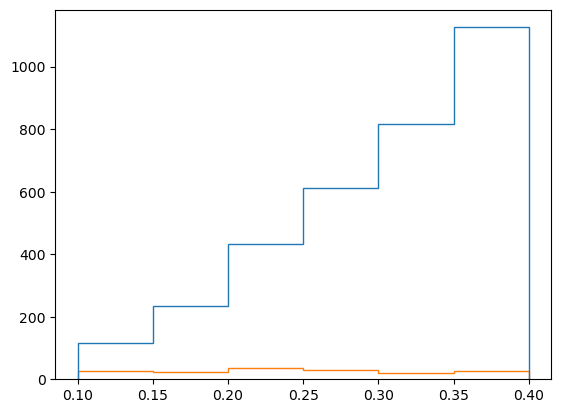

In [191]:
binning = np.linspace(0.1, 0.4, 7)
test = plt.hist([qsrs.z, four_lac.z]
        ,histtype="step"
        ,density=False
        ,bins=binning)[0]

In [192]:
min_4lac = min(test[1])
min_qsr = min(test[0])

# rels4lac = np.array([test[1][i]/min_4lac for i in range(len(binning)-1)])
rels4lac =  np.array([test[1][i]/test[1][0] for i in range(len(binning)-1)])
relsqsr = np.array([test[0][i]/min_qsr for i in range(len(binning)-1)])


In [193]:
test[0]

array([ 115.,  236.,  434.,  612.,  818., 1126.])

In [194]:
test[1]

array([25., 22., 37., 30., 21., 25.])

In [195]:
rels4lac


array([1.  , 0.88, 1.48, 1.2 , 0.84, 1.  ])

In [196]:
relsqsr


array([1.        , 2.05217391, 3.77391304, 5.32173913, 7.11304348,
       9.79130435])

In [197]:
forced_rels = (min_qsr)*rels4lac
forced_rels


array([115. , 101.2, 170.2, 138. ,  96.6, 115. ])

In [198]:

og_counts = test[0]


In [199]:
og_counts

array([ 115.,  236.,  434.,  612.,  818., 1126.])

In [200]:
sub = 0
while any(forced_rels > og_counts):
    sub+=1
    forced_rels = (min_qsr - sub)*rels4lac
    

In [201]:
set_rels = np.floor(forced_rels)

In [202]:
set_rels
# [112.,  99., 166., 135.,  94., 112., 202., 112.,  54., 108.,  90., 76.]
# [114.  , 100.32, 168.72, 136.8 ,  95.76, 114.  , 205.2 , 114.  , 54.72, 109.44,  91.2 ,  77.52]


# Z-MNIROR COUNTS [114.,  100.,  168.,  136.,   95.,  114.,  205.,  114.,   54.,  109.,   91.,   77.]


# QSO COUNTS (pre-mirror)        [114.,  237.,  434.,  603.,  818., 1120., 1509., 1923., 2265., 3006., 3744., 3978.]
# 4LAC COUNTS                    [25.,    22.,   37.,   30.,   21.,   25.,   45.,   25.,   12.,   24.,   20.,   17.]
# Z-MIRROR COUNTS (in plots)     [112.,   99.,  166.,  135.,   94.,  112.,  202.,  112.,   54.,  108.,   90.,   76.]
# Z-MIRROR COUNTS (method above) [114.,  100.,  168.,  136.,   95.,  114.,  205.,  114.,   54.,  109.,   91.,   77.]

array([115., 101., 170., 138.,  96., 115.])

In [203]:
sum(set_rels)

735.0

In [204]:
count_to_delete = og_counts - set_rels


In [205]:
count_to_delete

array([   0.,  135.,  264.,  474.,  722., 1011.])

In [190]:
def z_mirror(qsrs, binning, counts_to_delete):
    idx_buckets = []
    # count_to_delete = [2.000e+00, 1.380e+02, 2.680e+02, 4.680e+02, 7.240e+02, 1.008e+03,
    #    1.307e+03, 1.811e+03, 2.211e+03, 2.898e+03, 3.654e+03, 3.902e+03]
    # count_to_delete = [   0.,  137.,  266.,  467.,  723., 1006., 1304., 1809., 2211.,
    #    2897., 3653., 3901.]
    # count_to_delete = [1.000e+00, 5.390e+02, 1.596e+03, 2.910e+03, 5.003e+03, 7.447e+03]
    # count_to_delete = [   0., 1085., 1863., 2202., 3074., 3408.]
    # binning = np.linspace(0.4, 0.7, 7)
    for i in range(len(binning)-1):
        if i == len(binning)-2:
            too_high = qsrs.z > binning[i+1]    
        else:
            too_high = qsrs.z >= binning[i+1]
        too_low = qsrs.z < binning[i]
        bin_mask = ~too_high & ~too_low
        temp = qsrs[bin_mask]
        candidate_idx = temp.index.to_list()
        popped_idx = random.sample(candidate_idx, int(count_to_delete[i]))
        idx_buckets.append(popped_idx)
        qsrs.drop(popped_idx, axis='index', inplace=True)
    return (qsrs, idx_buckets)

In [185]:
binning

array([0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ])

In [186]:
len(qsrs)

19751

In [187]:
qsrs, _ = z_mirror(qsrs)

In [188]:
len(qsrs)

8119

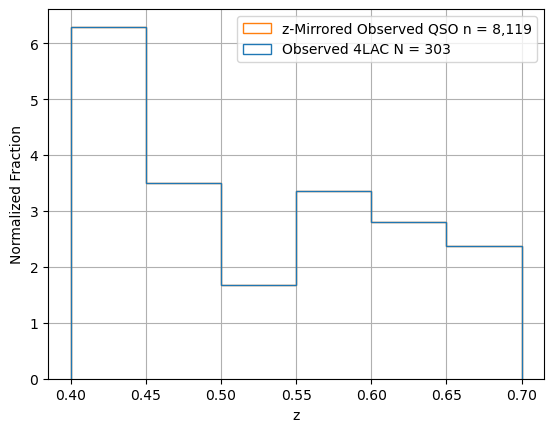

In [189]:
plt.hist([qsrs.z, four_lac.z], bins=binning, histtype="step", density=True )
plt.legend([f'z-Mirrored Observed QSO n = {len(qsrs):,}', F'Observed 4LAC N = {len(four_lac):,} '])
plt.xlabel('z')
plt.ylabel('Normalized Fraction')
plt.grid()

In [73]:
# zbin = [0.1, 0.4]
# p_vals =  [None]*1000
# for i in range(1000):
#     qsrs = sdss_dr16[is_qsr].copy()
#     # DROP ALL GALAXIES WITH z < 0.1
#     qsrs = qsrs[qsrs.z >= 0.1].copy()
#     qsrs, _ = z_mirror(qsrs)
#     p_vals[i] = stats.ks_2samp(qsrs[z_mask(qsrs, zbin)].Voidiness, four_lac[z_mask(four_lac, zbin)].Voidiness)[1]

(array([0.39543002, 1.12251102, 2.10470816, 3.13792854, 2.00266171,
        1.55620846, 1.454162  , 0.65054616, 0.19133711, 0.14031388]),
 array([0.06889096, 0.14728662, 0.22568229, 0.30407796, 0.38247362,
        0.46086929, 0.53926496, 0.61766062, 0.69605629, 0.77445196,
        0.85284762]),
 [<matplotlib.patches.Polygon at 0x316f34670>])

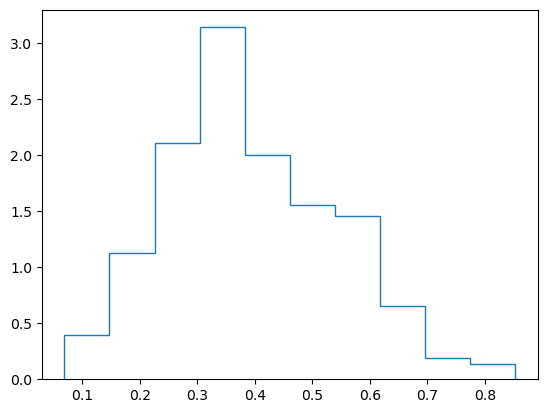

In [75]:
# plt.hist(p_vals, density=True, histtype="step")

Text(0.5, 1.0, 'z: [0.4, 0.7)')

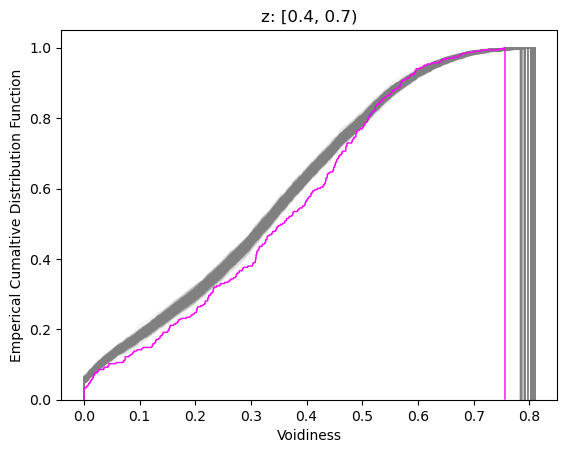

In [97]:
# zbin = [0.4, 0.7]
# p_vals =  [None]*1000
# for i in range(1000):
#     qsrs = sdss_dr16[is_qsr].copy()
#     # DROP ALL GALAXIES WITH z < 0.1
#     qsrs = qsrs[qsrs.z >= 0.1].copy()
#     qsrs, _ = z_mirror(qsrs)
#     plt.hist(qsrs.Voidiness, bins=1000, cumulative=True, histtype="step", alpha=0.1, density=True, color='0.5')
#     p_vals[i] = stats.ks_2samp(qsrs[z_mask(qsrs, zbin)].Voidiness, four_lac[z_mask(four_lac, zbin)].Voidiness)[1]
# # plt.hist(p_vals, density=True, histtype="step")
# plt.hist(four_lac.Voidiness, cumulative=True, histtype="step", color='magenta', bins=1000, density=True)
# plt.xlabel(xlabel='Voidiness')
# plt.ylabel("Emperical Cumaltive Distribution Function")
# plt.title("z: [0.4, 0.7)")

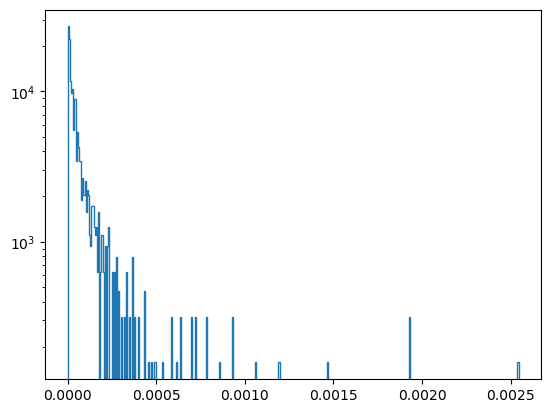

In [100]:
# plt.hist(p_vals, density=True, histtype="step",bins = 400)
# # plt.xlim((0, 0.0002))
# plt.ticklabel_format(style='sci', axis='x')
# plt.yscale('log')

In [95]:
np.std(p_vals)

0.00019719016292269164

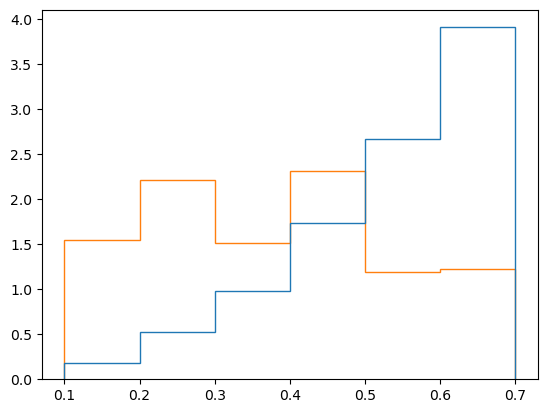

In [36]:
NFs = plt.hist([qsrs.z, four_lac.z]
        ,histtype="step"
        ,density=True
        ,bins=binning)[0]
curve_unequal = [NFs[0][i]  > NFs[1][i] for i in range(6)]

In [ ]:
curve_unequal

[True, False, False, True, True, False]

Text(0, 0.5, 'Normalized Fraction')

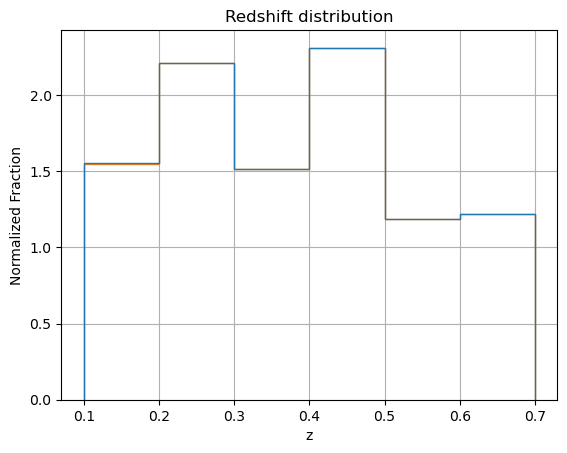

In [101]:
density_flag = True
test = plt.hist([qsrs.z, four_lac.z]
         ,histtype="step"
         ,density=density_flag
         ,bins=binning)
# plt.hist(four_lac.z
#          ,histtype="step"
#          ,density=density_flag)
plt.grid()
plt.xlabel('z')
plt.title('Redshift distribution')
plt.ylabel('Normalized Fraction')